In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import zscore
from glob import glob
from itertools import product

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import shapely
from shapely.ops import unary_union
from shapely.geometry import mapping, Polygon
# from src.grid_generation import *

In [2]:
# Month of data to load (unable to read more than one more due to pc memory bandwidth)
YEAR = '2022'
MONTH = '10'
MINUTES_WINDOW_SIZE = '15Min'

In [3]:
#Load data and filter essential columns
data = pd.read_parquet(f"../../data/Tlc-Trip-Record-Data/{YEAR}/yellow_tripdata_{YEAR}-{MONTH}.parquet")
data = data[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'total_amount']]
data

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,total_amount
0,2022-10-01 00:03:41,2022-10-01 00:18:39,249,107,15.95
1,2022-10-01 00:14:30,2022-10-01 00:19:48,151,238,9.30
2,2022-10-01 00:27:13,2022-10-01 00:37:41,238,166,12.36
3,2022-10-01 00:32:53,2022-10-01 00:38:55,142,239,12.35
4,2022-10-01 00:44:55,2022-10-01 00:50:21,238,166,9.10
...,...,...,...,...,...
3675406,2022-10-31 23:56:35,2022-11-01 00:10:11,137,50,19.14
3675407,2022-10-31 23:22:00,2022-10-31 23:28:00,142,161,14.30
3675408,2022-10-31 23:25:00,2022-10-31 23:48:00,186,45,27.34
3675409,2022-10-31 23:32:54,2022-10-31 23:33:02,264,263,22.20


In [4]:
# Join gdf geometry to data according to PULocationID
manhattan_gdf = gpd.read_file('../../data/new_data/taxi_zones/taxi_zones.shp')
manhattan_gdf = manhattan_gdf[manhattan_gdf.borough == 'Manhattan']

manhattan_gdf["DOLocationID"] = manhattan_gdf.LocationID
data = manhattan_gdf.merge(data, on='DOLocationID', how='inner')

In [5]:
# Change pickup and dropoff datetime to datetime format
data.tpep_pickup_datetime = pd.to_datetime(data["tpep_pickup_datetime"])
data.tpep_dropoff_datetime = pd.to_datetime(data["tpep_dropoff_datetime"])

In [6]:
# Extract year & month
data["y_m"] = pd.to_datetime(data["tpep_pickup_datetime"]).dt.strftime('%Y-%m')

In [7]:
# Filter date
mask = (data['y_m'] >= data['y_m'].head(1).values[0]) & (data['y_m'] <= data['y_m'].tail(1).values[0])
data = data.loc[mask]

In [8]:
# Get date only
data["y_m_d"] = pd.to_datetime(data["tpep_pickup_datetime"]).dt.strftime('%Y-%m-%d')

In [9]:
# Extract hour of a day for PU (12AM = 0, 11PM = 23)
data["hour"] = data.tpep_pickup_datetime.dt.hour

In [10]:
# Label rows according to 15 mins window
data["mins"] = data.tpep_pickup_datetime.dt.floor(MINUTES_WINDOW_SIZE).dt.minute

In [11]:
# Concat PULocationID with DOLocation
data['p2p'] = data[["PULocationID", "DOLocationID"]].astype(str).agg('_'.join, axis=1)

In [12]:
data

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,DOLocationID,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,total_amount,y_m,y_m_d,hour,mins,p2p
0,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2022-10-01 00:23:11,2022-10-01 00:34:18,114,12.30,2022-10,2022-10-01,0,15,114_4
1,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2022-10-01 00:15:06,2022-10-01 00:26:18,148,16.30,2022-10,2022-10-01,0,15,148_4
2,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2022-10-01 00:01:05,2022-10-01 00:13:09,229,16.80,2022-10,2022-10-01,0,0,229_4
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2022-10-01 00:10:13,2022-10-01 00:23:32,148,11.80,2022-10,2022-10-01,0,0,148_4
4,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2022-10-01 00:29:38,2022-10-01 00:39:44,114,14.30,2022-10,2022-10-01,0,15,114_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235181,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,2022-10-31 23:10:46,2022-10-31 23:22:51,142,18.13,2022-10,2022-10-31,23,0,142_263
3235182,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,2022-10-31 23:31:00,2022-10-31 23:52:00,144,23.42,2022-10,2022-10-31,23,30,144_263
3235183,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,2022-10-31 23:48:00,2022-11-01 00:09:00,80,31.12,2022-10,2022-10-31,23,45,80_263
3235184,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,2022-10-31 23:55:38,2022-11-01 00:07:14,237,15.46,2022-10,2022-10-31,23,45,237_263


In [13]:
a = data['DOLocationID'].unique()
print(len(a))

66


In [14]:
# Merge the grid ids of data to the grid geoPandas dataframe
pu_count = pd.DataFrame()
pu_count['count'] = data.groupby(['DOLocationID', 'y_m_d', 'hour', 'mins']).size()
pu_count['ave_total_amount'] = data.groupby(['DOLocationID', 'y_m_d', 'hour', 'mins'])['total_amount'].agg(['mean'])
pu_count['LocationID'] = pu_count.index.get_level_values('DOLocationID')
pu_count['y_m_d'] = pu_count.index.get_level_values('y_m_d')
pu_count['hour'] = pu_count.index.get_level_values('hour')
pu_count['mins'] = pu_count.index.get_level_values('mins')
pu_count['time_slot'] = pd.to_datetime(pu_count['y_m_d'] + ' ' + pu_count['hour'].astype(str) + ':' + pu_count['mins'].astype(str))
pu_count = manhattan_gdf.merge(pu_count, on='DOLocationID', how='inner')

In [15]:
pu_count

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID_x,borough,geometry,DOLocationID,count,ave_total_amount,LocationID_y,y_m_d,hour,mins,time_slot
0,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,16,16.656250,4,2022-10-01,0,0,2022-10-01 00:00:00
1,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,11,15.141818,4,2022-10-01,0,15,2022-10-01 00:15:00
2,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,9,16.875556,4,2022-10-01,0,30,2022-10-01 00:30:00
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,7,16.094286,4,2022-10-01,0,45,2022-10-01 00:45:00
4,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,6,15.060000,4,2022-10-01,1,0,2022-10-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168921,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,28,24.956429,263,2022-10-31,22,45,2022-10-31 22:45:00
168922,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,21,15.976190,263,2022-10-31,23,0,2022-10-31 23:00:00
168923,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,18,20.417778,263,2022-10-31,23,15,2022-10-31 23:15:00
168924,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,21,20.310000,263,2022-10-31,23,30,2022-10-31 23:30:00


In [16]:
# Pivot table
pu_count_table = pu_count.pivot_table(index="time_slot", columns="DOLocationID", values="count")
pu_count_table.reset_index().rename_axis(None, axis=1)
pu_count_table = pu_count_table.fillna(0)
pu_count_table.sort_values(by='time_slot', inplace = True) 

In [17]:
pu_count_table

DOLocationID,4,12,13,24,41,42,43,45,48,50,...,237,238,239,243,244,246,249,261,262,263
time_slot,,,,,,,,,,,,,,,,,,,,,
2022-10-01 00:00:00,16.0,0.0,16.0,4.0,22.0,15.0,1.0,6.0,49.0,27.0,...,25.0,32.0,28.0,5.0,10.0,25.0,54.0,15.0,19.0,38.0
2022-10-01 00:15:00,11.0,0.0,6.0,5.0,16.0,9.0,3.0,4.0,51.0,16.0,...,21.0,32.0,25.0,4.0,9.0,36.0,47.0,15.0,25.0,35.0
2022-10-01 00:30:00,9.0,0.0,15.0,3.0,13.0,6.0,3.0,5.0,46.0,15.0,...,20.0,22.0,22.0,8.0,10.0,23.0,35.0,8.0,21.0,35.0
2022-10-01 00:45:00,7.0,1.0,4.0,5.0,9.0,7.0,5.0,6.0,39.0,17.0,...,18.0,32.0,14.0,6.0,7.0,18.0,31.0,7.0,20.0,30.0
2022-10-01 01:00:00,6.0,0.0,6.0,8.0,13.0,7.0,2.0,4.0,39.0,21.0,...,23.0,20.0,22.0,4.0,9.0,19.0,37.0,9.0,13.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31 22:45:00,9.0,0.0,7.0,2.0,16.0,5.0,4.0,2.0,36.0,12.0,...,21.0,17.0,20.0,4.0,7.0,19.0,16.0,8.0,21.0,28.0
2022-10-31 23:00:00,12.0,0.0,7.0,5.0,14.0,9.0,5.0,1.0,27.0,10.0,...,15.0,21.0,21.0,3.0,10.0,15.0,14.0,3.0,22.0,21.0
2022-10-31 23:15:00,7.0,0.0,1.0,4.0,8.0,8.0,3.0,5.0,24.0,14.0,...,10.0,18.0,26.0,3.0,7.0,17.0,11.0,5.0,13.0,18.0


In [18]:
pu_count_table.to_csv(f'../../Time_Series_CSVs_Supply/{YEAR}/{YEAR}_{MONTH}_Time_Series.csv', index=True, header=True)

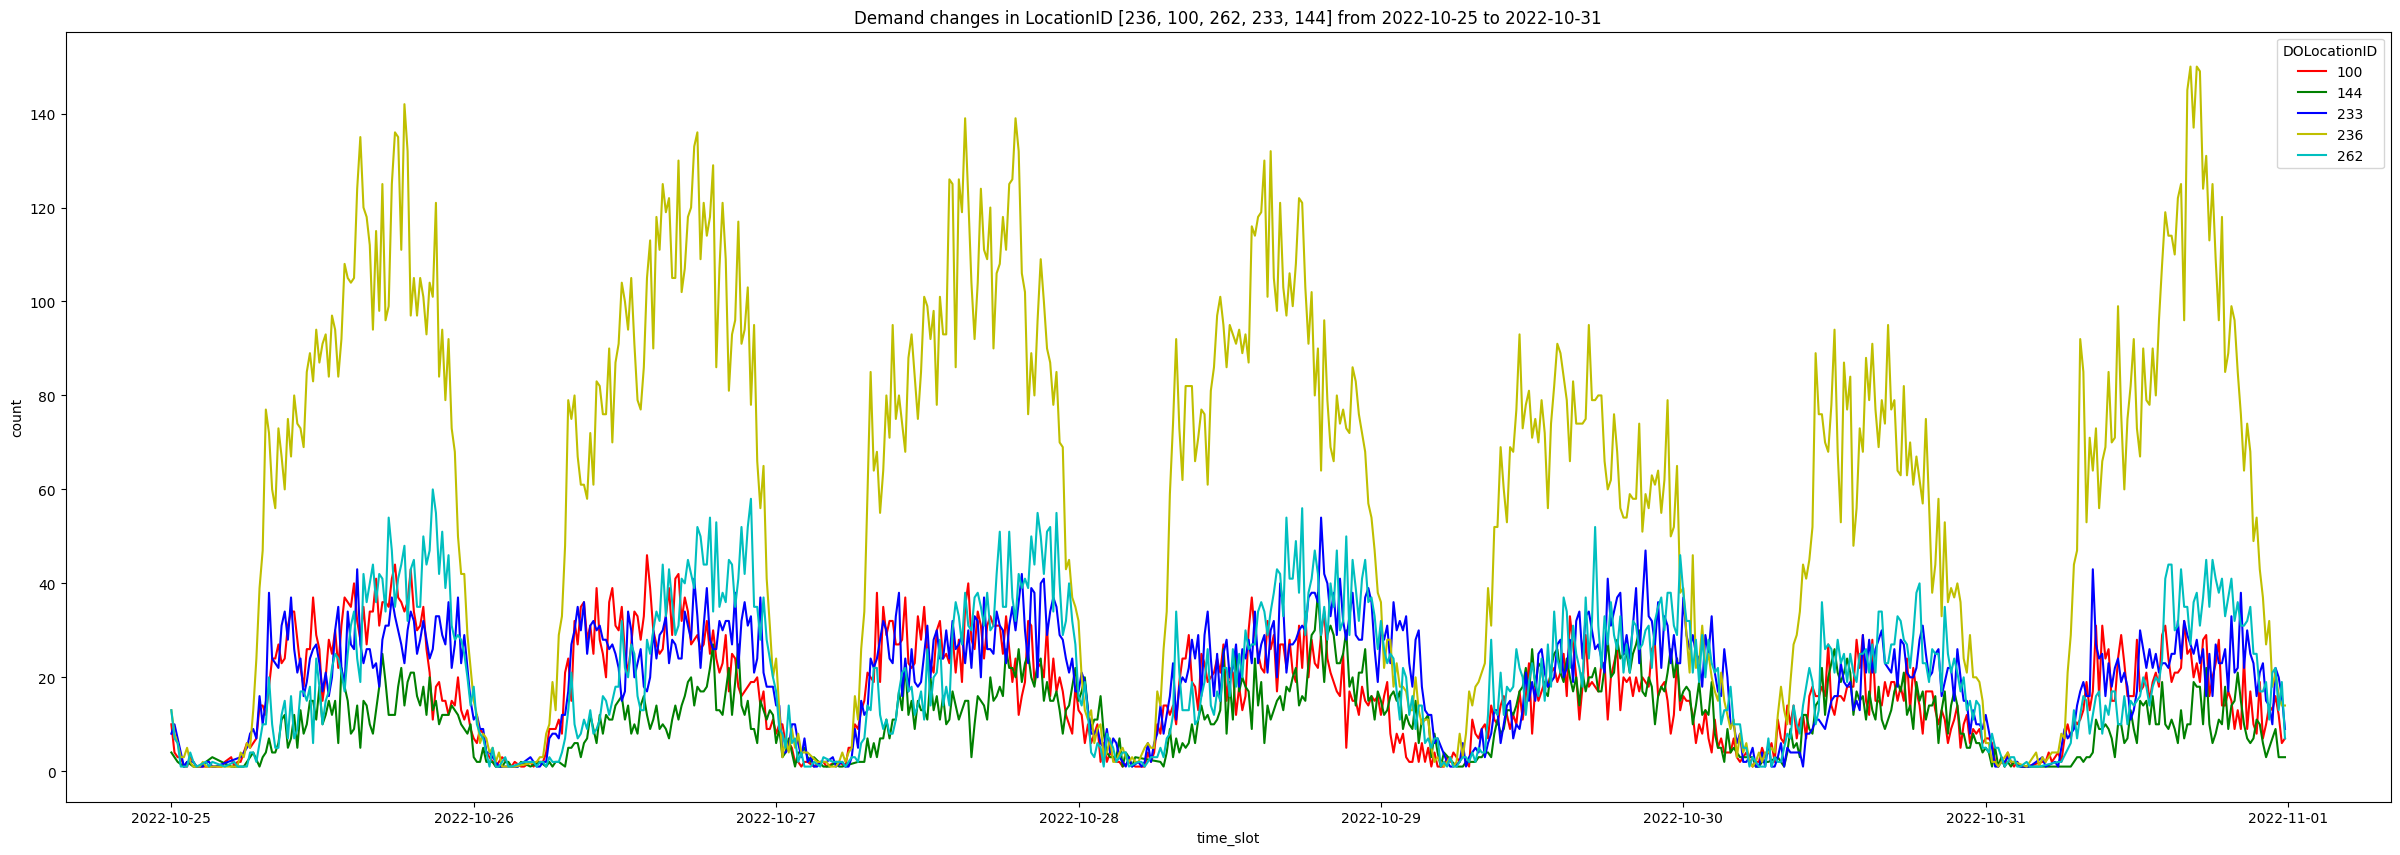

In [19]:
# Plot demand changes of 5 randomly selected regions across 7 days
days_of_data = 7
pu_count.sort_values(by='time_slot', ascending = False, inplace = True)
date_range = [x for x in pd.to_datetime(pu_count.y_m_d).dt.strftime('%Y-%m-%d').unique()[:days_of_data]]

pu_count_gr_7days = pu_count.loc[(pd.to_datetime(pu_count.y_m_d)).isin(date_range)]
rand_loc = list(pu_count_gr_7days.DOLocationID.sample(n=5, random_state=1))
pu_count_gr_7days = pu_count_gr_7days.loc[pu_count_gr_7days.DOLocationID.isin(rand_loc)]

fig, ax = plt.subplots(figsize=(30, 10))
ax.set_title(f"Demand changes in LocationID {rand_loc} from {pu_count_gr_7days.y_m_d.iloc[-1]} to {pu_count_gr_7days.y_m_d.iloc[0]}")
pu_plot_7 = sns.lineplot(ax=ax, data=pu_count_gr_7days,  x="time_slot", y="count", hue="DOLocationID", palette=['r', 'g', 'b', 'y', 'c'])